# Лабораторная работа №3
## по предмету "Системы искусственного интеллекта"
### БВТ2101 Юдин Артём

Целью работы является изучение методов регуляризации.


### Задание 1

Выгрузите данные из датасета. Изучите колонки, проверьте наличие пропусков. Постройте матрицу корреляции между признаками и целевой переменной. Сделайте выводы, что показывает эта матрица.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer


import typing as tp
import warnings

In [2]:
df = pd.read_csv("../csv/AISP2.csv")
df.sample(5)

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
68,ASUS,Intel,Core i3,11th,4 GB,DDR4,256 GB,0 GB,Windows,32-bit,0 GB,Casual,No warranty,No,No,41990,3 stars,0,0
471,DELL,Intel,Core i5,11th,8 GB,DDR4,256 GB,1024 GB,Windows,64-bit,0 GB,Casual,1 year,No,Yes,58990,4 stars,114,9
710,DELL,AMD,Ryzen 5,Not Available,4 GB,DDR4,512 GB,0 GB,Windows,64-bit,4 GB,Casual,1 year,No,No,98920,3 stars,0,0
712,acer,AMD,Ryzen 5,Not Available,4 GB,DDR4,512 GB,0 GB,Windows,64-bit,0 GB,Casual,1 year,No,No,49990,4 stars,47,6
41,Lenovo,Intel,Core i3,11th,8 GB,DDR4,256 GB,0 GB,Windows,64-bit,0 GB,Casual,1 year,Yes,Yes,53990,4 stars,299,41


In [3]:
df.isna().sum()

brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd                  0
hdd                  0
os                   0
os_bit               0
graphic_card_gb      0
weight               0
warranty             0
Touchscreen          0
msoffice             0
Price                0
rating               0
Number of Ratings    0
Number of Reviews    0
dtype: int64

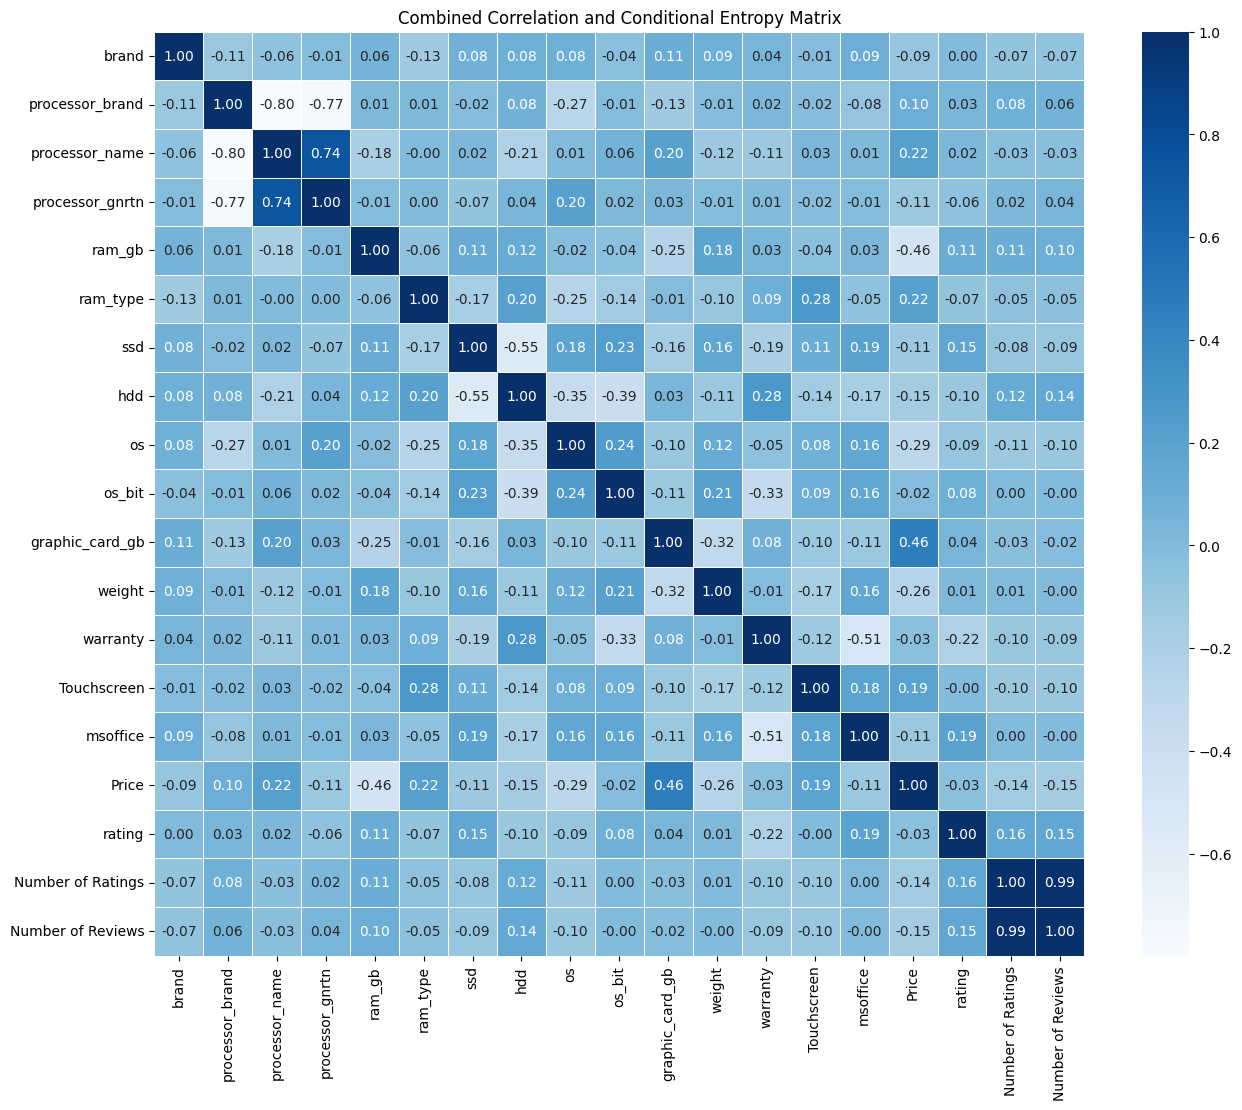

In [4]:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

numerical_corr = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(15, 12))
sns.heatmap(numerical_corr, annot=True, cmap='Blues', linewidths=0.5, fmt=".2f")
plt.title('Combined Correlation and Conditional Entropy Matrix')
plt.show()


In [5]:
df = pd.read_csv("../csv/AISP2.csv")
df = df.drop(["Number of Reviews", "processor_brand",], axis="columns")

cat_cols = [
    "brand",
    'processor_name',
    'processor_gnrtn',
    'ram_gb',
    'ram_type',
    'ssd',
    'hdd',
    'os',
    'os_bit',
    'graphic_card_gb',
    'weight',
    'warranty',
    'Touchscreen',
    'msoffice',
    'rating'
]

num_cols = ['Number of Ratings']
target_col = ['Price']

In [6]:
cat_trans = OneHotEncoder(handle_unknown="ignore", drop="first")
# cat_trans = LabelEncoder()
num_trans = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_trans, num_cols),
        ('cat2', cat_trans, cat_cols),
    ]
)

X = df.drop(target_col, axis="columns")
X = preprocessor.fit_transform(X).toarray()
y = df[target_col].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    random_state=42)



In [7]:
my = [1e+10] * 3
sk = [1e+10] * 3

### Задание 2

Реализуйте с нуля алгоритм линено регрессии  без использования регуляризации.

In [8]:
class MyLinearRegression:
    """Scratch realization of Regression

    Examples
    _________________________________________________________
    >>> model = MyLinearRegression() 
    >>> model.fit(np.ones((12, 30)), np.ones(12), 5, 12, 0.1)
    >>> model.predict(np.ones((1, 30)))
    """
    def __init__(self):
        self.w = None

    def _batch(self,
              X: np.ndarray, 
              y: np.ndarray, 
              batch_size: int) -> tp.Generator[tuple[np.ndarray], None, None]:
        """Batches X and y with shuffle.
        
        Args
        _______________________________________________________
        - X (np.ndarray) - array of features
        - y (np.ndarray) - array of labels
        - batch_size (int) - number of samples in one batch"""
        if (X.shape[0] % batch_size):
            warnings.warn(f"Cannot devide X with {X.shape[0]} examples to {batch_size}. Last batch will be droped", RuntimeWarning)
        perm = np.random.permutation(X.shape[0])

        for batch_ in range(X.shape[0] // batch_size):
            indexes = perm[batch_*batch_size:(batch_+1)*batch_size]
            yield(
                X[indexes],
                y[indexes],
            )

    def _grad(self, X: np.ndarray, y:np.ndarray) -> np.ndarray:
        """Gradient calculation
        
        Args
        _____________________________________
        - X (np.ndarray) - array of features.
        - y (np.ndarray) - array of labels.
        """
        y_pred = self.predict(X)
        grad_basic = X.T @ (y_pred - y)
        return grad_basic


    def fit(self, 
            X_train: np.ndarray, 
            y_train: np.ndarray,
            epochs: int = 10,
            batch_size: int = 12, 
            lr: float = 0.1) -> list[np.float64]:
        """Model training
        
        Args
        ________________________________________________________________
        - X_train (np.ndarray) - array of features
        - y_train (np.ndarray) - array of labels
        - epochs (int) - number of train epochs. Default: 10.
        - batch_size (int) - number of examples in batch. Default: 12.
        - lr (float) - learning rate for model. Default: 0.1."""
        assert X_train.shape[0] == y_train.shape[0], \
            f"{X_train.shape}, {y_train.shape}"        

        if self.w is None:
            self.w = np.random.randn(X_train.shape[1], 1)

        losses = []

        for epoch in range(epochs):
            for X_batched, y_batched in self._batch(X=X_train,
                                                   y=y_train,
                                                   batch_size=batch_size):
                grad = self._grad(X_batched, y_batched)
                self.w -= grad * lr / np.sqrt(epoch + 1)

                loss = rmse(y_batched, self.predict(X_batched))
                losses.append(loss)
            
        return losses


    def predict(self, X: np.ndarray) -> np.ndarray:
        """Model predictions
        
        Args
        ________________________________________
        - X (np.ndarray) - array of features."""
        return X @ self.w

Обучите модель.

In [9]:
np.random.seed(42)
lin_reg = MyLinearRegression()
losses = lin_reg.fit(X_train=X_train,
            y_train=y_train, 
            epochs=100, 
            batch_size=20, 
            lr=1e-2)

my[0] = (rmse(y_test, lin_reg.predict(X_test)))
my[0]

23730.679194313823

In [10]:
lin_reg_sk = LinearRegression()
lin_reg_sk.fit(X_train, y_train)
sk[0] = (rmse(y_test, lin_reg_sk.predict(X_test)))
sk[0]

23068.015200209757

### Задание 3

Реализуйте с нуля алгоритм линейной регрессии для многоклассовой классификации с L1-регуляризацией.

$$L1 = \alpha \cdot \mathrm{sign}(w)$$

In [11]:
class L1LinearRegression(MyLinearRegression):
    """Scratch realization of Regression with L1 regularization

    Args
    _______________________________________________________________
    - reg_coef (float) - L1 regularization coefficient. Default: 1.

    Examples
    _________________________________________________________
    >>> model = L2LinearRegression(0.1) 
    >>> model.fit(np.ones((30, 12)), np.ones((30, 1)), 5, 10, 0.1)
    >>> model.predict(np.ones((10, 12)))
    array([[-3.08941408e+12],
       [-3.08941408e+12],
       [-3.08941408e+12],
       [-3.08941408e+12],
       [-3.08941408e+12],
       [-3.08941408e+12],
       [-3.08941408e+12],
       [-3.08941408e+12],
       [-3.08941408e+12],
       [-3.08941408e+12]])
    """
    def __init__(self, reg_coef: float = 1.):
        super().__init__()
        self.reg_coef = reg_coef

    def _grad(self, X: np.ndarray, y:np.ndarray) -> np.ndarray:
        """Gradient calculation
        
        Args
        _____________________________________
        - X (np.ndarray) - array of features.
        - y (np.ndarray) - array of labels.
        """
        grad_basic = super()._grad(X, y)

        def soft_sign(x, eps: float = 1e-7):
            if abs(x) > eps:
                return np.sign(x)
            return x / eps
        np_soft_sign = np.vectorize(soft_sign)
        l1_reg = self.reg_coef * np_soft_sign(self.w)
        return grad_basic + l1_reg
    

Обучите модель.

In [12]:
np.random.seed(42)
lasso = L1LinearRegression()
lasso.fit(X_train=X_train,
            y_train=y_train, 
            epochs=100, 
            batch_size=20, 
            lr=1e-2)
my[1] = (rmse(y_test, lasso.predict(X_test)))
my[1]

23730.938471973215

In [13]:
lasso_sk = Lasso(max_iter=10)
lasso_sk.fit(X_train, y_train)
sk[1] = (rmse(y_test, lasso_sk.predict(X_test)))
sk[1]

c:\Users\Артём\Desktop\лекции\AIS\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.321e+11, tolerance: 1.522e+08
  model = cd_fast.enet_coordinate_descent(


21992.826363222048

### Задание 4

Реализуйте с нуля алгоритм линейной регрессии для многоклассовой классификации с L2-регуляризацией.

$$L2 = 2 \cdot \alpha \cdot w$$

In [14]:
class L2LinearRegression(MyLinearRegression):
    """Scratch realization of Regression with L2 regularization

    Args
    _______________________________________________________________
    - reg_coef (float) - L2 regularization coefficient. Default: 1.

    Examples
    _________________________________________________________
    >>> model = L2LinearRegression(0.1) 
    >>> model.fit(np.ones((30, 12)), np.ones((30, 1)), 5, 10, 0.1)
    >>> model.predict(np.ones((10, 12)))
    array([[-3.18129497e+12],
       [-3.18129497e+12],
       [-3.18129497e+12],
       [-3.18129497e+12],
       [-3.18129497e+12],
       [-3.18129497e+12],
       [-3.18129497e+12],
       [-3.18129497e+12],
       [-3.18129497e+12],
       [-3.18129497e+12]])
    """
    def __init__(self, reg_coef: float = 1.):
        super().__init__()
        self.reg_coef = reg_coef

    def _grad(self, X: np.ndarray, y:np.ndarray) -> np.ndarray:
        """Gradient calculation
        
        Args
        _____________________________________
        - X (np.ndarray) - array of features.
        - y (np.ndarray) - array of labels.
        """
        grad_basic = super()._grad(X, y)
        l2_reg = 2 * self.reg_coef * self.w
        return grad_basic + l2_reg

Обучите модель.

In [15]:
X_train.shape, y_train.shape

((740, 60), (740, 1))

In [16]:
np.random.seed(42)
ridge = L2LinearRegression()
ridge.fit(X_train=X_train,
            y_train=y_train, 
            epochs=100, 
            batch_size=20, 
            lr=1e-2)
my[2] = rmse(y_test, ridge.predict(X_test))
my[2]

30440.267897660215

In [17]:
ridge = Ridge()
ridge.fit(X_train, y_train)
sk[2] = rmse(y_test, ridge.predict(X_test))
sk[2]

22982.413578993488

### Задание 5

Сделайте выводы о результатах обучения.

Моя реализация L2 оказалась самой далёкой от эталонной, но вместе с тем разница между ними составила не так и много в относительных значения погрешности

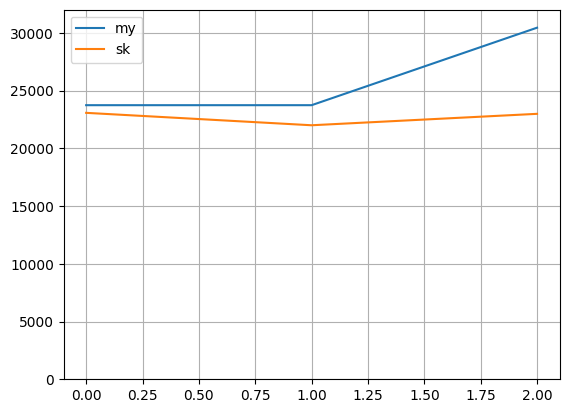

In [18]:
plt.plot(my, label="my")
plt.plot(sk, label="sk")
plt.ylim((0, 32_000))
plt.grid()
plt.legend()
plt.show()